# Восстановление золота из руды

 Компания "Цифры" разрабатывает решения для эффективной работы промышленных предприятий.

`Цель:` оптимизировать производство так, чтобы не запускать предприятие с убыточными характеристиками.


`Задача:` подготовить прототип модели машинного обучения Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды.   

`Входные данные:` данные с параметрами добычи и очистки.

Данные находятся в трёх файлах:
- gold_recovery_train_new.csv — обучающая выборка;
- gold_recovery_test_new.csv — тестовая выборка;
- gold_recovery_full_new.csv — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

`Этапы:`

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


## Подготовка данных

### Подключение библиотек

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression

In [2]:
# Игнорирование предупреждений
warnings.filterwarnings('ignore')

### Загрузка данных

In [3]:
full = pd.read_csv('/datasets/gold_recovery_full_new.csv') 

train = pd.read_csv('/datasets/gold_recovery_train_new.csv') 
test = pd.read_csv('/datasets/gold_recovery_test_new.csv') 

In [4]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


### Проверка расчета эффективности обогащения золота

По заданию первоначально нужно проверить, что эффективность обогащения рассчитана правильно. Вычислить её на обучающей выборке для признака rougher.output.recovery. Найти MAE между расчётами и значением признака.

In [5]:
train['rougher.output.recovery']

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Name: rougher.output.recovery, Length: 14149, dtype: float64

In [6]:
C = train['rougher.output.concentrate_au']
T = train['rougher.output.tail_au']
F = train['rougher.input.feed_au']

In [7]:
train['rougher.output.recovery_check'] = C * (F - T) * 100 / (F * (C - T))

In [8]:
train['rougher.output.recovery_check'] 

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Name: rougher.output.recovery_check, Length: 14149, dtype: float64

In [9]:
mean_absolute_error(train['rougher.output.recovery'],train['rougher.output.recovery_check'])

1.1131451184435918e-14

###### Значение очень маленькое, значит данные очень близки. Можно считать, что эффективность посчитана верно.

### Признаки, недоступные в тестовой выборке

Проанализируем признаки, недоступные в тестовой выборке.

In [10]:
test.shape

(5290, 53)

In [11]:
#test.info()

In [12]:
columns_drop = list(train.columns.difference(test.columns))
columns_drop

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.recovery_check',
 'rougher.output.tail_ag',
 'rougher.ou

###### Отсутствуют параметры output с каждого этапа,  а также расчётные характеристики, потому что замеряются и/или рассчитываются значительно позже. А также отсутствует целевой признак 'rougher.output.recovery'

Стоит удалить признаки не входящие в тест из полной выборки, при формировании датасетов (кроме целевого)

In [13]:
columns_drop.remove('final.output.recovery')
columns_drop.remove('rougher.output.recovery')
columns_drop

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery_check',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.tail_pb',
 'rougher.ou

In [14]:
train = train.drop(columns = columns_drop)
print(train.shape)
print(test.shape)

(14149, 55)
(5290, 53)


### Предобработка данных

In [15]:
#train.info()

Необходимо преобразовать тип в столбце с датой.

In [16]:
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%dT%H:%M:%S')
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%dT%H:%M:%S')
full['date'] = pd.to_datetime(full['date'], format='%Y-%m-%dT%H:%M:%S')

Просмотрим столбцы с долей пропусков больше 5 процентов в каждом наборе данных.

In [19]:
for df in [train,test,full]:
    for column in train.columns:
        if train[column].isna().mean() > 0.01:
            print(column,  train[column].isna().mean()) # доля пропусков
            
        
    print()    

rougher.input.feed_size 0.010177397695950243
rougher.input.floatbank11_xanthate 0.03024948759629656
rougher.state.floatbank10_e_air 0.030814898579404906
secondary_cleaner.state.floatbank2_a_air 0.01533677291681391

rougher.input.feed_size 0.010177397695950243
rougher.input.floatbank11_xanthate 0.03024948759629656
rougher.state.floatbank10_e_air 0.030814898579404906
secondary_cleaner.state.floatbank2_a_air 0.01533677291681391

rougher.input.feed_size 0.010177397695950243
rougher.input.floatbank11_xanthate 0.03024948759629656
rougher.state.floatbank10_e_air 0.030814898579404906
secondary_cleaner.state.floatbank2_a_air 0.01533677291681391



Наибольшая доля пропусков ~ 3%.
По условию данные в соседние периоды близки, следовательно можем заполнить пропуски следующим значением, удалив перед этим пропуски в целевых признаках

In [20]:
train['final.output.recovery']

0        70.541216
1        69.266198
2        68.116445
3        68.347543
4        66.927016
           ...    
14144    73.755150
14145    69.049291
14146    67.002189
14147    65.523246
14148    70.281454
Name: final.output.recovery, Length: 14149, dtype: float64

In [21]:
train['rougher.output.recovery'] = train['rougher.output.recovery'].dropna()
train['final.output.recovery'] = train['final.output.recovery'].dropna()

full['rougher.output.recovery'] = full['rougher.output.recovery'].dropna()
full['final.output.recovery'] = full['final.output.recovery'].dropna()

In [22]:
train=train.fillna(method= 'bfill')
test=test.fillna(method= 'bfill')
full=full.fillna(method= 'bfill')

In [23]:
for df in [train,full]:
    print(df.isna().sum())

date                                          0
final.output.recovery                         0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate       

Проверим на дубликаты.

In [24]:
for df in [train,test,full]:
    print(df.duplicated().sum())

0
0
0


## Анализ данных

##### Посмотрим как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

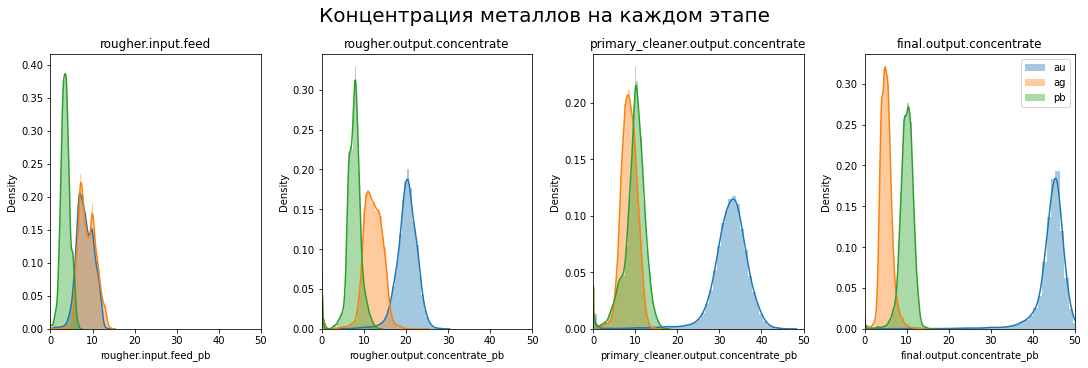

In [25]:
metals = ['au', 'ag', 'pb']

processes= ['rougher.input.feed',
           'rougher.output.concentrate',
           'primary_cleaner.output.concentrate',
           'final.output.concentrate']

fig, axs = plt.subplots(1, len(processes), figsize=(15, 5), constrained_layout=True)
fig.suptitle('Концентрация металлов на каждом этапе', fontsize=20)


for process,ax in zip(processes, axs):
    ax.set_title(process)
    for metal in metals:
        #train.columns.str.contains(process+'_'+metal)
        sns.distplot(full.loc[:,process+'_'+metal].dropna(),label=metal, ax=ax)
        ax.set_xlim([0, 50])
        
plt.legend()
plt.show()


Концентрация золота значительно (~ х2) росла на каждом этапе. Остальные металлы выросли совсем немного.

##### Сравним распределениe размеров гранул сырья на обучающей и тестовой выборках

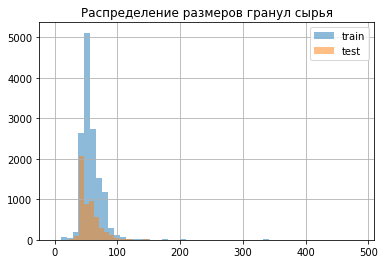

In [26]:
train['rougher.input.feed_size'].dropna().hist(bins = 50,alpha=0.5, label='train')
test['rougher.input.feed_size'].dropna().hist(bins = 50,alpha=0.5, label='test')
plt.legend()
plt.title('Распределениe размеров гранул сырья')
plt.show()

###### Если распределения сильно отличаются друг от друга, оценка модели будет неправильной. Здесь распределения похожи, значит можем строоить модель.
Видно, что есть незначительное смещение распределения от нормального в сторону увеличения гранул. Также, на тестовой выборке имеется большее значение очень маленьких гранул. 

##### Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [27]:
# Создадим дополнительный суммарный столбец 
df = [full]

for data in df:
    
    data.loc[:,'feed_sum'] = data.loc[:,['rougher.input.feed_au',
                                'rougher.input.feed_ag',
                                'rougher.input.feed_pb',
                                'rougher.input.feed_sol']].sum(axis=1)

    data.loc[:, 'rougher_sum'] = data.loc[:, ['rougher.output.concentrate_au',
                                'rougher.output.concentrate_ag',
                                'rougher.output.concentrate_pb',
                                'rougher.output.concentrate_sol']].sum(axis=1)

    
    data.loc[:, 'final_sum'] = data.loc[:, ['final.output.concentrate_au',
                               'final.output.concentrate_ag',
                               'final.output.concentrate_pb',
                               'final.output.concentrate_sol']].sum(axis=1)

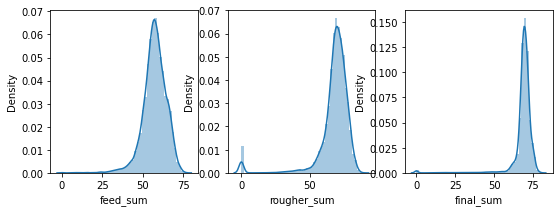

In [28]:
for data in df:
    f, axes = plt.subplots(1,3, figsize=(9, 3))
    sns.distplot(data['feed_sum'],  ax=axes[0])
    sns.distplot(data['rougher_sum'],  ax=axes[1])   
    sns.distplot(data['final_sum'], ax=axes[2])   

На плотах видно аномалии, их нужно удалить из тестовой и тренировочной выборки.
В целом отдельно по каждому веществу ноль может быть (не всегда же есть крупинки золота в руде), а ноль суммарно - вряд ли (в руде хоть что-то но будет). А если мы имеем ноль, значит большая вероятность неточности в измерениях.

In [29]:
test = test[(full['rougher_sum'] > 10) & (full['final_sum'] > 10)]
train = train[(full['rougher_sum'] > 10) & (full['final_sum'] > 10)]

In [30]:
test.shape
train.shape

(13798, 55)

## Модель

Напишим функцию для вычисления итоговой sMAPE (метрика качества).

Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке

In [32]:
numeric = test.drop('date',axis=1).columns

In [33]:
def sMAPE(target, predict):
    
    sMAPE = ((abs(target - predict) / ((abs(target) + abs(predict)) / 2)).mean() * 100)
    
    return sMAPE

smape = make_scorer(sMAPE, greater_is_better=False)

In [34]:
def full_sMAPE(rougher_sMAPE, final_sMAPE):
    
    full_sMAPE = 0.25*rougher_sMAPE + 0.75*final_sMAPE
    
    return full_sMAPE 

Разделим данные.

In [35]:
features_train_rougher = train.drop(['date','rougher.output.recovery','final.output.recovery'],axis=1)
target_train_rougher = train['rougher.output.recovery']

features_train_final = train.drop(['date','rougher.output.recovery','final.output.recovery'],axis=1)
target_train_final = train['final.output.recovery']

test_full = full[full['date'].isin(test['date'])]
features_test = test.drop(['date'],axis=1)
target_test_rougher = test_full['rougher.output.recovery']
target_test_final = test_full['final.output.recovery']


In [36]:
list(train.columns.difference(test.columns))

['final.output.recovery', 'rougher.output.recovery']

In [37]:
reg_rougher = LinearRegression()
reg_final = LinearRegression()

In [38]:
forrest_rougher=RandomForestRegressor(random_state=42)

param_grid = { 
    'n_estimators': [10,100],
    'max_depth' : [2,3,4,5,6],
}

CV_forrest_rougher = GridSearchCV(estimator=forrest_rougher, param_grid=param_grid, cv= 5,scoring=smape)
CV_forrest_rougher.fit(features_train_rougher, target_train_rougher)


print(CV_forrest_rougher.best_params_)

{'max_depth': 6, 'n_estimators': 10}


In [39]:
forrest_final=RandomForestRegressor(random_state=42)

param_grid = { 
    'n_estimators': [10,100],
    'max_depth' : [2,3,4,5,6],
}

CV_forrest_final = GridSearchCV(estimator=forrest_rougher, param_grid=param_grid, cv= 5, scoring=smape)
CV_forrest_final.fit(features_train_final, target_train_final)


print(CV_forrest_rougher.best_params_)

{'max_depth': 6, 'n_estimators': 10}


In [40]:
forrest_rougher =  RandomForestRegressor(random_state=42,  n_estimators= 100, max_depth=6)
forrest_final = RandomForestRegressor(random_state=42,  n_estimators= 100, max_depth=6)

In [41]:
forrest_rougher.fit(features_train_rougher,target_train_rougher)
forrest_final.fit(features_train_final,target_train_final)


RandomForestRegressor(max_depth=6, random_state=42)

In [42]:
scores = cross_val_score(reg_rougher,features_train_rougher, target_train_rougher,cv=5, scoring=smape)
scores

array([-13.11890921,  -7.42950921, -18.82851549, -15.0913339 ,
        -8.886689  ])

In [43]:
target_train_rougher.values

array([87.10776293, 86.84326051, 86.84230826, ..., 88.89057853,
       89.858126  , 89.51495973])

In [44]:
scores = cross_val_score(forrest_rougher,features_train_rougher, target_train_rougher,cv=5, scoring=smape)
scores

array([ -7.98408658,  -6.89807942, -14.07766369, -16.18242946,
        -8.87945844])

In [45]:
scores = cross_val_score(reg_final,features_train_final, target_train_final,cv=5, scoring=smape)
scores

array([-13.2428284 , -10.18171298, -10.56896666, -10.88002196,
       -14.66715721])

In [46]:
scores = cross_val_score(reg_rougher,features_train_rougher, target_train_rougher,cv=5, scoring=smape)
scores

array([-13.11890921,  -7.42950921, -18.82851549, -15.0913339 ,
        -8.886689  ])

In [47]:
forrest_rougher.fit(features_train_rougher,target_train_rougher)
forrest_final.fit(features_train_final,target_train_final)

RandomForestRegressor(max_depth=6, random_state=42)

In [48]:
predict_rougher_forrest = forrest_rougher.predict(features_test)
predict_final_forrest =forrest_final.predict(features_test)

In [49]:
reg_rougher.fit(features_train_rougher,target_train_rougher)
reg_final.fit(features_train_final,target_train_final)


LinearRegression()

In [50]:
predict_rougher_reg = reg_rougher.predict(features_test)
predict_final_reg = reg_final.predict(features_test)

In [51]:
full_sMAPE(sMAPE(target_test_rougher,predict_rougher_forrest),sMAPE(target_test_final,predict_final_forrest))

10.04531950841754

In [52]:
full_sMAPE(sMAPE(target_test_rougher,predict_rougher_reg),sMAPE(target_test_final,predict_final_reg))

9.951761714889008

## Проверка моделей на адекватность

Определим две константные модели и сравним результаты с результатами наших моделей.

In [53]:
dummy_reg_rougher = DummyRegressor(strategy="mean")
dummy_reg_rougher.fit(features_train_rougher, target_train_rougher)

prediction_rougher = dummy_reg_rougher.predict(features_test)



In [54]:
dummy_reg_final = DummyRegressor(strategy="mean")
dummy_reg_final.fit(features_train_final,target_train_final)

prediction_final = dummy_reg_final.predict(features_test)


In [55]:
full_sMAPE(sMAPE(target_test_rougher,prediction_rougher),sMAPE(target_test_final,prediction_final))

10.29750321993464

###### Вывод: ошибка линейной регрессии меньше ошибки константной модели